In [135]:
#Khai bao thu vien
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler # chuan hoa du lieu
from keras.callbacks import ModelCheckpoint # luu lai huan luyen tot nhat
from tensorflow.keras.models import load_model #tai mo hinh

# Cac lop xay dung mo hinh
from keras.models import Sequential #dau vao
from keras.layers import LSTM #hoc phu thuoc
from keras.layers import Dropout # tranh hoc tu
from keras.layers import Dense # dau ra

#kiem tra do chinh xacs
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error # do sai so tuyet doi trung binh
from sklearn.metrics import mean_absolute_percentage_error #do phan tram sai so tuyet doi trung binh
from sklearn.metrics import mean_squared_error

import seaborn as sns



In [136]:
df = pd.read_csv('/Users/macbook/Desktop/KHDL project/datatrainmodel.csv')
df

,start,dengue
0,1994-02-01,1095
1,1994-03-01,1199
2,1994-04-01,1719
3,1994-05-01,2208
4,1994-06-01,3686
...,...,...
198,2010-08-01,15169
199,2010-09-01,15395
200,2010-10-01,14411
201,2010-11-01,10070


In [137]:
from pandas.io.sql import to_datetime
# dinh dang cau truc thoi gian
df["start"] = pd.to_datetime(df['start'], format="%Y-%m-%d")


In [138]:
df.info()
# 1 cot ngay theo thoi gian, 1 cot so nguyen, k co gia tri trong

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 203 entries, 0 to 202
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   start   203 non-null    datetime64[ns]
 1   dengue  203 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 3.3 KB


In [139]:
df.describe()

,start,dengue
count,203,203.000000
mean,2002-07-01 19:02:04.137931008,5280.970443
min,1994-02-01 00:00:00,579.000000
25%,1998-04-16 00:00:00,2172.000000
50%,2002-07-01 00:00:00,3873.000000
75%,2006-09-16 00:00:00,7167.500000
max,2010-12-01 00:00:00,28315.000000
std,NaN,4394.767737


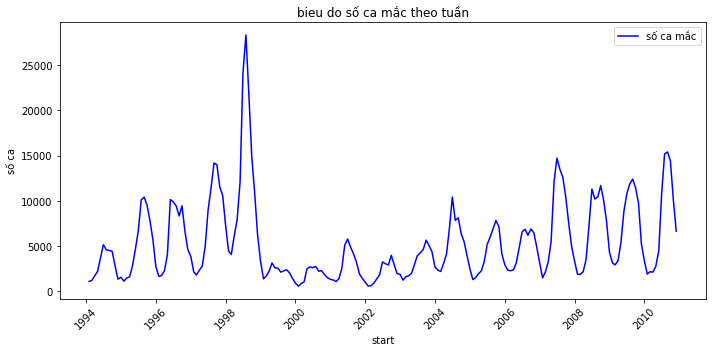

In [140]:
#Ve bieu do
plt.figure(figsize = (10,5))
plt.plot(df['start'],df['dengue'], label='số ca mắc', color='blue')
plt.title('bieu do số ca mắc theo tuần')
plt.xlabel('start')
plt.ylabel('số ca')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

         start  dengue
53  1998-07-01   24087
54  1998-08-01   28315
55  1998-09-01   21713
56  1998-10-01   14931
161 2007-07-01   14723
198 2010-08-01   15169
199 2010-09-01   15395


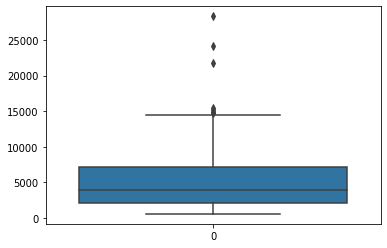

In [141]:
#Sử dụng IQR xác định ngoại lai
sns.boxplot(data=df['dengue'])

Q1 = df['dengue'].quantile(0.25)
Q3 = df['dengue'].quantile(0.75)
IQR = Q3 - Q1

# Tìm và in ra các điểm ngoại lai
outliers_df = df[(df['dengue'] < (Q1 - 1.5 * IQR)) | (df['dengue'] > (Q3 + 1.5 * IQR))]

print(outliers_df)

Empty DataFrame
Columns: [start, dengue]
Index: []


<Axes: >

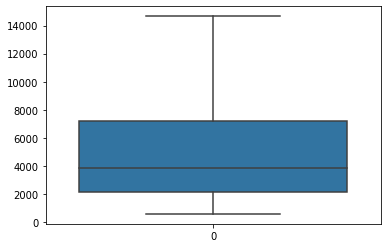

In [142]:
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Thay thế các điểm ngoại lai bằng giới hạn dưới hoặc trên
df['dengue'] = df['dengue'].apply(lambda x: lower_bound if x < lower_bound else (upper_bound if x > upper_bound else x))

# In ra các điểm ngoại lai đã được thay thế
outliers_df = df[(df['dengue'] < (Q1 - 1.5 * IQR)) | (df['dengue'] > (Q3 + 1.5 * IQR))]
print(outliers_df)
sns.boxplot(data=df['dengue'])


In [166]:
df1= pd.DataFrame(df,columns=['start','dengue'])
df1

,start,dengue
0,1994-02-01,1095.00
1,1994-03-01,1199.00
2,1994-04-01,1719.00
3,1994-05-01,2208.00
4,1994-06-01,3686.00
...,...,...
198,2010-08-01,14660.75
199,2010-09-01,14660.75
200,2010-10-01,14411.00
201,2010-11-01,10070.00


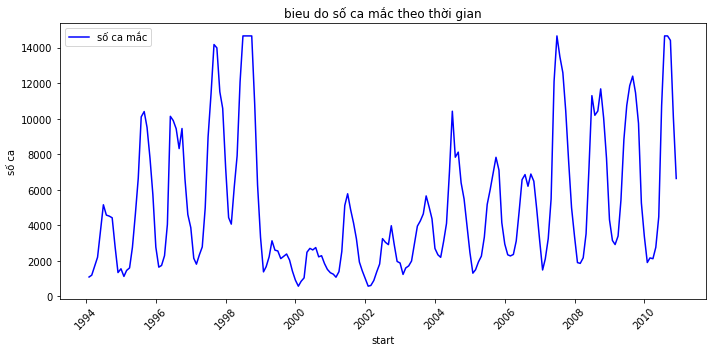

In [167]:
plt.figure(figsize = (10,5))
plt.plot(df1['start'],df1['dengue'], label='số ca mắc', color='blue')
plt.title('bieu do số ca mắc theo thời gian')
plt.xlabel('start')
plt.ylabel('số ca')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [146]:

df1.index=df1['start']
df1.drop("start",axis =1, inplace = True)

In [147]:
data=df1.values

train_data = data[:160] # 160 mau dau tien
test_data = data[160:]
data

array([[ 1095.  ],
       [ 1199.  ],
       [ 1719.  ],
       [ 2208.  ],
       [ 3686.  ],
       [ 5160.  ],
       [ 4580.  ],
       [ 4520.  ],
       [ 4428.  ],
       [ 2777.  ],
       [ 1346.  ],
       [ 1559.  ],
       [ 1128.  ],
       [ 1464.  ],
       [ 1607.  ],
       [ 2766.  ],
       [ 4648.  ],
       [ 6653.  ],
       [10106.  ],
       [10406.  ],
       [ 9515.  ],
       [ 7778.  ],
       [ 5735.  ],
       [ 2779.  ],
       [ 1650.  ],
       [ 1746.  ],
       [ 2295.  ],
       [ 4055.  ],
       [10137.  ],
       [ 9900.  ],
       [ 9438.  ],
       [ 8321.  ],
       [ 9451.  ],
       [ 6614.  ],
       [ 4610.  ],
       [ 3873.  ],
       [ 2151.  ],
       [ 1817.  ],
       [ 2345.  ],
       [ 2788.  ],
       [ 4989.  ],
       [ 8978.  ],
       [11399.  ],
       [14176.  ],
       [13989.  ],
       [11515.  ],
       [10583.  ],
       [ 7224.  ],
       [ 4441.  ],
       [ 4071.  ],
       [ 6156.  ],
       [ 7913.  ],
       [1208

In [148]:
#chuan hoa du lieu
sc = MinMaxScaler(feature_range=(0,1))
sc_train = sc.fit_transform(data)

In [149]:
# tao vong lap cac gia tri
x_train, y_train =[],[]
for i in range(50,len(train_data)):
    x_train.append(sc_train[i-50:i,0])
    y_train.append(sc_train[i,0])

In [150]:
x_train

[array([0.03664317, 0.04402862, 0.08095585, 0.11568164, 0.22064019,
        0.32531468, 0.28412662, 0.27986578, 0.2733325 , 0.15608855,
        0.05446766, 0.06959362, 0.03898663, 0.0628473 , 0.07300229,
        0.1553074 , 0.28895556, 0.43133843, 0.67654943, 0.6978536 ,
        0.63458022, 0.51122907, 0.36614767, 0.15623058, 0.07605589,
        0.08287322, 0.12185985, 0.24684432, 0.67875087, 0.66192057,
        0.62911215, 0.54978962, 0.63003533, 0.42856889, 0.28625703,
        0.23391979, 0.11163385, 0.08791521, 0.12541055, 0.15686971,
        0.3131713 , 0.59644575, 0.76837041, 0.96557601, 0.95229641,
        0.77660802, 0.71042307, 0.47188737, 0.27425569, 0.24798054]),
 array([0.04402862, 0.08095585, 0.11568164, 0.22064019, 0.32531468,
        0.28412662, 0.27986578, 0.2733325 , 0.15608855, 0.05446766,
        0.06959362, 0.03898663, 0.0628473 , 0.07300229, 0.1553074 ,
        0.28895556, 0.43133843, 0.67654943, 0.6978536 , 0.63458022,
        0.51122907, 0.36614767, 0.15623058, 0.

In [151]:
# xep du lieu thanh 1 mang
x_train = np.array(x_train)
y_train = np.array(y_train)

#xep thanh mang 1 chieu
x_train= np.reshape(x_train,(x_train.shape[0],x_train.shape[1],1))
y_train = np.reshape(y_train,(y_train.shape[0],1))

In [152]:
x_train.shape
y_train.shape

(110, 1)

# Xây dựng và huấn luyện mô hình

In [153]:
model = Sequential()
model.add(LSTM(units=128, input_shape=(x_train.shape[1],1),return_sequences=True))
model.add(LSTM(units=64))
model.add(Dropout(0.5))
model.add(Dense(1))
model.compile(loss='mean_absolute_error',optimizer='adam')
#su dung trinh toi uu hoa adam

2024-01-01 23:38:26.972316: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-01-01 23:38:26.974945: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-01-01 23:38:26.977164: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

In [154]:
save_model="Notebooks/data/save_model.hdf5"
best_model = ModelCheckpoint(save_model,monitor='loss',verbose=2,save_best_only=True, mode = 'auto')
history=model.fit(x_train,y_train,epochs=100, batch_size=50, verbose=2, callbacks=[best_model])

Epoch 1/100


2024-01-01 23:39:12.521266: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-01-01 23:39:12.528171: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-01-01 23:39:12.534285: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus


Epoch 1: loss improved from inf to 0.19357, saving model to Notebooks/data/save_model.hdf5
3/3 - 9s - loss: 0.1936 - 9s/epoch - 3s/step
Epoch 2/100

Epoch 2: loss improved from 0.19357 to 0.16821, saving model to Notebooks/data/save_model.hdf5
3/3 - 1s - loss: 0.1682 - 622ms/epoch - 207ms/step
Epoch 3/100

Epoch 3: loss improved from 0.16821 to 0.15935, saving model to Notebooks/data/save_model.hdf5
3/3 - 1s - loss: 0.1594 - 750ms/epoch - 250ms/step
Epoch 4/100

Epoch 4: loss improved from 0.15935 to 0.15507, saving model to Notebooks/data/save_model.hdf5
3/3 - 0s - loss: 0.1551 - 475ms/epoch - 158ms/step
Epoch 5/100

Epoch 5: loss did not improve from 0.15507
3/3 - 1s - loss: 0.1611 - 583ms/epoch - 194ms/step
Epoch 6/100

Epoch 6: loss improved from 0.15507 to 0.14606, saving model to Notebooks/data/save_model.hdf5
3/3 - 1s - loss: 0.1461 - 522ms/epoch - 174ms/step
Epoch 7/100

Epoch 7: loss improved from 0.14606 to 0.14110, saving model to Notebooks/data/save_model.hdf5
3/3 - 0s - l

In [155]:
# du lieu train
y_train = sc.inverse_transform(y_train) # số ca thực tế
final_model=load_model('Notebooks/data/save_model.hdf5')
y_train_predict = final_model.predict(x_train)
y_train_predict= sc.inverse_transform(y_train_predict) # số ca dự đoán

2024-01-01 23:48:54.000886: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-01-01 23:48:54.005459: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-01-01 23:48:54.013030: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

4/4 [==============================] - 2s 45ms/step


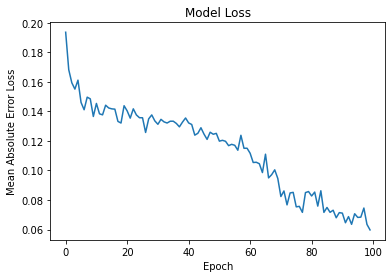

In [156]:
import matplotlib.pyplot as plt

# Vẽ biểu đồ cho quá trình huấn luyện
plt.plot(history.history['loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error Loss')
plt.show()


# Sử dụng mô hình

In [157]:
# xu ly du lieu test
test = df1[len(train_data)-50:].values
test = test.reshape(-1,1)
sc_test=sc.transform(test)

x_test =[]
for i in range(50,test.shape[0]):
    x_test.append(sc_test[i-50:i,0])
x_test=np.array(x_test)
x_test= np.reshape(x_test,(x_test.shape[0],x_test.shape[1],1))

# du lieu test
y_test = data[160:]
y_test_predict= final_model.predict(x_test)
y_test_predict=sc.inverse_transform(y_test_predict)

2/2 [==============================] - 0s 18ms/step


In [158]:
y_test_predict

array([[ 5308.945 ],
       [10172.214 ],
       [14465.437 ],
       [13845.981 ],
       [10528.807 ],
       [ 6848.0396],
       [ 4194.151 ],
       [ 3016.213 ],
       [ 3045.348 ],
       [ 3353.0408],
       [ 3905.832 ],
       [ 4435.263 ],
       [ 5152.85  ],
       [ 7115.9033],
       [10149.161 ],
       [10144.847 ],
       [ 8576.309 ],
       [ 7720.5747],
       [ 6482.177 ],
       [ 5143.521 ],
       [ 3596.8591],
       [ 3131.5476],
       [ 3626.7144],
       [ 4644.363 ],
       [ 6337.943 ],
       [ 9001.09  ],
       [11084.165 ],
       [11588.214 ],
       [10678.5   ],
       [ 8613.777 ],
       [ 6412.137 ],
       [ 3613.0898],
       [ 2313.8547],
       [ 2151.2222],
       [ 3000.5798],
       [ 3925.6614],
       [ 4700.2793],
       [ 5640.93  ],
       [ 9118.627 ],
       [13309.516 ],
       [13908.628 ],
       [11611.282 ],
       [ 6611.289 ]], dtype=float32)

## Độ chính xác

/var/folders/6w/n21p66td2895by94s7yx_2f40000gn/T/ipykernel_21497/3804912678.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data1['du doan']= y_train_predict
/var/folders/6w/n21p66td2895by94s7yx_2f40000gn/T/ipykernel_21497/3804912678.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data1['du doan'] = y_test_predict


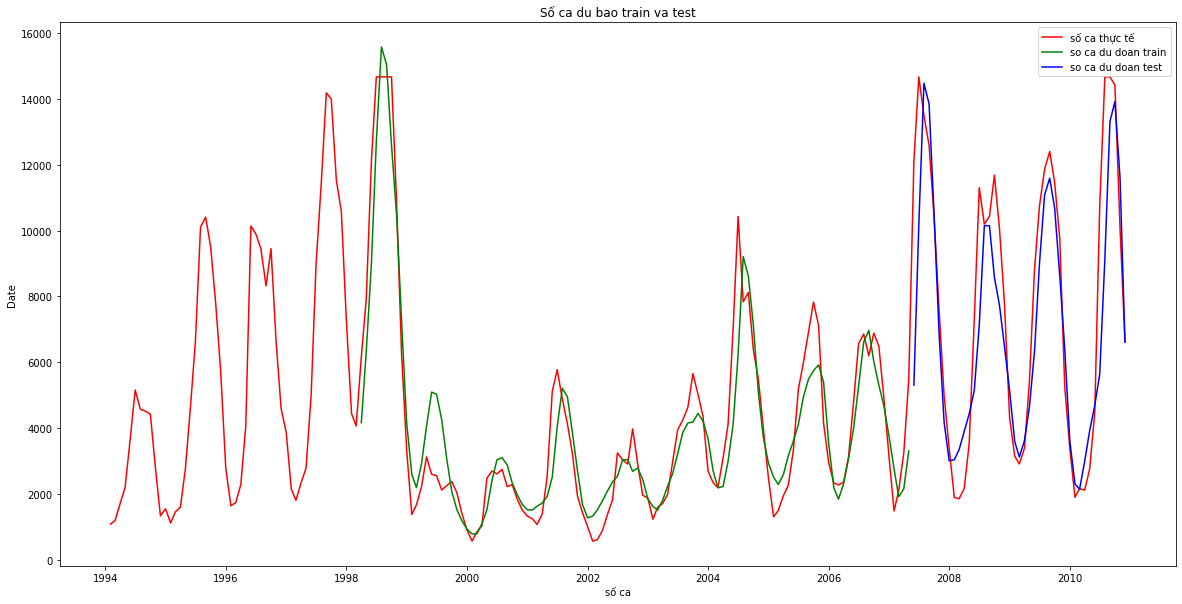

In [159]:
#lap bieu do so sanh
train_data1 = df1[50:160]
test_data1 = df1[160:]

plt.figure(figsize=(20,10))
plt.plot(df1,label='số ca thực tế',color = 'red') # 
train_data1['du doan']= y_train_predict
plt.plot(train_data1['du doan'], label='so ca du doan train', color = 'green') #du bao train
test_data1['du doan'] = y_test_predict
plt.plot(test_data1['du doan'], label = 'so ca du doan test', color = 'blue') #du bao test
plt.title('Số ca du bao train va test')
plt.xlabel('số ca')
plt.ylabel('Date')
plt.legend()
plt.show()

In [160]:
print('do phu hop tap train', r2_score(y_train,y_train_predict)) 
print('Sai so tuyet doi trung binh tap train:', mean_absolute_error(y_train,y_train_predict))
print('Mean Squared Error tập huấn luyện:', mean_squared_error(y_train, y_train_predict))


do phu hop tap train 0.8745750919465443
Sai so tuyet doi trung binh tap train: 808.0453019575639
Mean Squared Error tập huấn luyện: 1205691.6988619114


In [161]:
train_data1

,dengue,du doan
start,,
1998-04-01,6156.00,4171.454590
1998-05-01,7913.00,6322.066406
1998-06-01,12082.00,8965.229492
1998-07-01,14660.75,12685.840820
1998-08-01,14660.75,15569.900391
...,...,...
2007-01-01,3158.00,3773.751709
2007-02-01,1491.00,2768.819824
2007-03-01,2114.00,1924.396606


In [162]:
print('do phu hop tap test', r2_score(y_test,y_test_predict)) 

print('Sai so tuyet doi trung binh tap test:', mean_absolute_error(y_test,y_test_predict))
print('Mean Squared Error tập kiểm tra:', mean_squared_error(y_test, y_test_predict))


do phu hop tap test 0.750316618764526
Sai so tuyet doi trung binh tap test: 1452.2985612736193
Mean Squared Error tập kiểm tra: 4536367.025018984


In [163]:
test_data1


,dengue,du doan
start,,
2007-06-01,12099.00,5308.944824
2007-07-01,14660.75,10172.213867
2007-08-01,13487.00,14465.436523
2007-09-01,12588.00,13845.981445
2007-10-01,10449.00,10528.806641
2007-11-01,7564.00,6848.039551
2007-12-01,5001.00,4194.150879
2008-01-01,3390.00,3016.212891
2008-02-01,1907.00,3045.347900


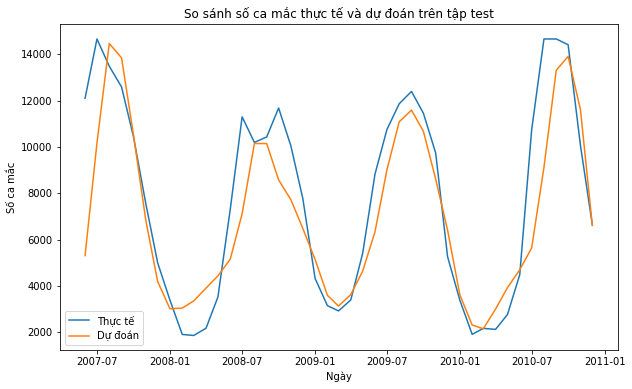

In [164]:
plt.figure(figsize=(10, 6))
plt.plot(test_data1.index, test_data1['dengue'], label='Thực tế')
plt.plot(test_data1.index, test_data1['du doan'], label='Dự đoán')
plt.xlabel('Ngày')
plt.ylabel('Số ca mắc')
plt.title('So sánh số ca mắc thực tế và dự đoán trên tập test')
plt.legend()
plt.show()


In [74]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_absolute_percentage_error

r2_test = r2_score(test_data1['dengue'], test_data1['du doan'])
mae_test = mean_absolute_error(test_data1['dengue'], test_data1['du doan'])
mape_test = mean_absolute_percentage_error(test_data1['dengue'], test_data1['du doan'])

print('R2 Score (tập test):', r2_test)
print('Mean Absolute Error (tập test):', mae_test)
print('Mean Absolute Percentage Error (tập test):', mape_test)

R2 Score (tập test): 0.34958361166527196
Mean Absolute Error (tập test): 2275.588004178779
Mean Absolute Percentage Error (tập test): 0.29861681014022495
